## Importing libraries

In [1]:
import torch
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)
import itertools

## Defining helper functions

In case the user has a GPU, this will significantly speed up parameter optimization

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Function to import images

In [3]:
# desired size of the output image
imsize = 36

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

Function to plot images

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(1, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image, cmap = "gist_gray")
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

Get the images and label them

This code block makes use of the fact that images are within files whose filenames contain their labels; using the file extension to create a list of corresponding labels

In [5]:
label_list = []
for numeric_class in glob.glob("/home/jeremydiaz/DeepDevanagari/data/numerals/*"):
    label = numeric_class[-1]
    for file_index in range(len(glob.glob(numeric_class + '/*'))):
        feature_image = glob.glob(numeric_class + '/*')[file_index]
        label_list.append(label)
        if label == label_list[0]:
            if file_index == 0:
                images = image_loader(feature_image).type(dtype)
            else:
                images = torch.cat([images, image_loader(feature_image).type(dtype)])
        else:
            images = torch.cat([images, image_loader(feature_image).type(dtype)])

### Quick visualization

The 123th image and its label

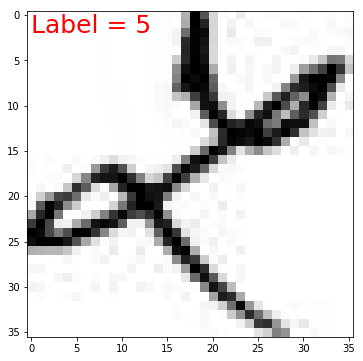

In [6]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
imshow(images[123].data)
ax.annotate("Label = " + label_list[123], xy = (0, 2), color= 'red', fontsize = 25)
plt.show()

# Getting the labels ready for PyTorch modelling
label_list = Variable(torch.from_numpy(np.asarray(label_list, dtype = int)))

## Creating train and test sets

In [7]:
images_train, images_test, Y_train, Y_test = train_test_split(images.data.numpy(),
                                                              label_list.data.numpy(),
                                                              test_size = 0.3)

images_train = Variable(torch.from_numpy(images_train))
images_test = Variable(torch.from_numpy(images_test))
Y_train = Variable(torch.from_numpy(Y_train))
Y_test = Variable(torch.from_numpy(Y_test))

## Defining and training the model

Defining the CNN architecture, loss function, and parameter-updating method

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(9*9*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
cnn = CNN()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())

The training

In [9]:
loss_list = []
test_loss_list = []
test_output_list = []

for epoch in range(151):
    
    minibatch_indices = torch.randperm(len(images_train))[0:50]
    
    minibatch_images = images_train[minibatch_indices]
    minibatch_Y = Y_train[minibatch_indices]
    
    optimizer.zero_grad()
    
    outputs = cnn(minibatch_images)
    test_outputs = cnn(images_test)
    
    loss = loss_function(outputs, minibatch_Y)
    test_loss = loss_function(test_outputs, Y_test)
    
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.data.numpy()[0])
    test_loss_list.append(test_loss.data.numpy()[0])
    
    if (epoch % 15) == 0:
        print('Finished epoch %0.6f' % epoch + '!')
        
    if epoch == 150:
        
        final_test_outputs = test_outputs.data.numpy()
        
Y_test_list = Y_test.data.numpy().tolist()

Finished epoch 0.000000!
Finished epoch 15.000000!
Finished epoch 30.000000!
Finished epoch 45.000000!
Finished epoch 60.000000!
Finished epoch 75.000000!
Finished epoch 90.000000!
Finished epoch 105.000000!
Finished epoch 120.000000!
Finished epoch 135.000000!
Finished epoch 150.000000!


Visualization of the training

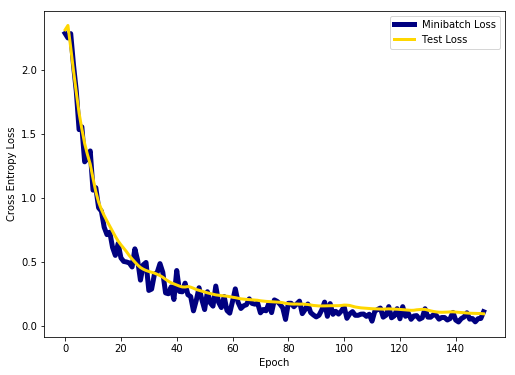

In [10]:
plt.plot(range(151), loss_list, c = 'navy', lw = 5, label = 'Minibatch Loss')
plt.plot(range(151), test_loss_list, c = 'gold', lw = 3, label = 'Test Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend();

## Evaluating performance

Predictions are currently in the form of confidence score arrays (length = 10), where true labels are single values (length = 1)

The next block converts the highest score's `range()` index into the single-value prediction

In [11]:
predicted_class_list = []

for instance_array in final_test_outputs:
    
    score_list = []
    
    for class_index in range(0, 10):
        
        score_list.append(instance_array[class_index])
        
        score_array = np.asarray(score_list)
        
    highest_score = np.max(score_array)
    
    for class_index2 in range(0, 10):
        
        if score_list[class_index2] == highest_score:
            
            predicted_class_list.append(class_index2)

### Confusion matrix

Defining and plotting the confusion matrix

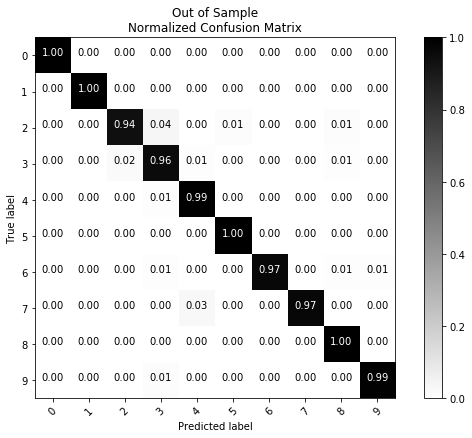

In [12]:
# Defining confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting
plot_confusion_matrix(confusion_matrix(Y_test_list, predicted_class_list),
                      classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      normalize = True,
                      title = 'Out of Sample\nNormalized Confusion Matrix')



### Accuracy

In [13]:
print("This convolutional neural network was able classify Devanagari numbers with %0.6f" % (accuracy_score(Y_test_list, predicted_class_list) * 100) + "% accuracy!")

This convolutional neural network was able classify Devanagari numbers with 98.032407% accuracy!


## Performance gallery

Plotting 3 **randomly selected** test set images, along with their true and predicted labels

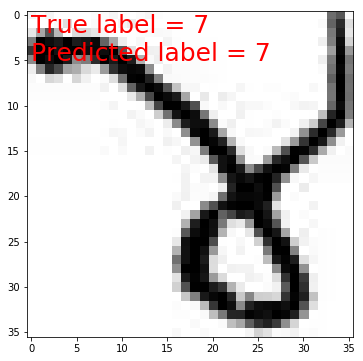

In [14]:
# The random selection
randomized_index = np.random.choice(len(images_test))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
imshow(images[randomized_index].data)
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'red', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'red', fontsize = 25)
plt.show()

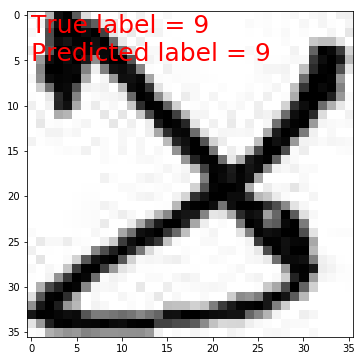

In [15]:
randomized_index = np.random.choice(len(images_test))

fig = plt.figure()
ax = fig.add_subplot(111)
imshow(images[randomized_index].data)
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'red', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'red', fontsize = 25)
plt.show()

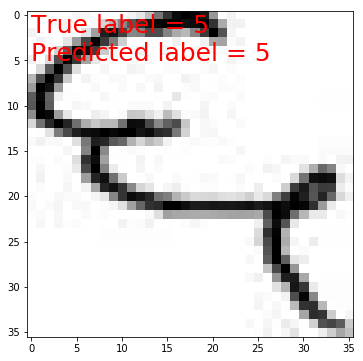

In [16]:
randomized_index = np.random.choice(len(images_test))

fig = plt.figure()
ax = fig.add_subplot(111)
imshow(images[randomized_index].data)
ax.annotate("True label = " + str(Y_test_list[randomized_index]), xy = (0, 2), color= 'red', fontsize = 25)
ax.annotate("Predicted label = " + str(predicted_class_list[randomized_index]), xy = (0, 5), color= 'red', fontsize = 25)
plt.show()